## MSDS: 7337 - Natural Language Processing
**Author: Trace Smith**
**Homework Assignment: 2**
________

In [27]:
import os
import bs4
import re; print("Regex",re.__version__)
import nltk; print("NLTK",nltk.__version__)
import tqdm; print("TQDM",tqdm.__version__)
import pandas as pd; print("Pandas",pd.__version__)
from urllib import request; print("Request",request.__version__)
from bs4 import BeautifulSoup; print("BeautifulSoup",bs4.__version__)
from string import punctuation
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt; print("Matplotlib",bs4.__version__)
%matplotlib inline

# WordCloud
import wordcloud
from wordcloud import WordCloud; print("Wordcloud",wordcloud.__version__)

Regex 2.2.1
NLTK 3.3
TQDM 4.11.2
Pandas 0.24.1
Request 3.5
BeautifulSoup 4.7.1
Matplotlib 4.7.1
Wordcloud 1.5.0


____
### Get URL Links to All Children's Instructional Books (Bookshelf)

In [28]:
def get_urls(url_landing):
    """
    Parse HTML Document for URL Links to EBooks
    """
    doc = request.urlopen(url_landing).read().decode('utf8')
    soup = BeautifulSoup(doc.lower(),"html.parser")
    
    # Get URLs to all Ebooks
    ebook_url = ['http:{}'.format(tag.attrs['href']) for tag in soup.find_all(href=True,class_='extiw')]
    
    urls = []
    for url in tqdm.tqdm(ebook_url):
        doc = request.urlopen(url).read().decode('utf8')
        soup = BeautifulSoup(doc.lower(),"html.parser")
        
        # Get Download Link (HTML) for Each Book
        urls.append(['http:{}'.format(tag.attrs['href'])  for tag in 
                    soup.find_all(href=True,class_='link')][0])
    
    print('Total URLs to Process: ',len(urls))
    return urls

if __name__ == '__main__':
    
    url = 'http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)'
    url_all = get_urls(url)

100%|██████████| 104/104 [02:14<00:00,  1.25s/it]

Total URLs to Process:  104


### NLP Pipeline to Preprocess each Ebook

- Preprocess, Tokenize, Compute Lexical Diversity and Vocabulary Size

In [55]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

def nlp_pipeline(url):
    
    """
    NLP Pipeline for Gutenberg EBoooks
    :url - input url reference link to ebook
    Returns dictionary of meta info, tokens, vocabulary size, lexical diversity
    """
    
    # Get Ebook
    doc = request.urlopen(url).read()
    soup = BeautifulSoup(doc,'html.parser')
    
    # Title
    title = [t.get_text(strip=True) for t in soup.find_all('title')][0]
    
    # Get Tags in Body (exclude license) - including title and headers + body text
    doc = request.urlopen(url).read()
    soup = BeautifulSoup(doc,'html.parser')
    
    # Remove Unwanted Text from <table> in <p> tags
    for i in soup.find_all('p'):
        for ii in i.find_all('table'):
            ii.extract()
    
    # Get Tags within Body
    text = [w.find_all(['title','h1','h2','h3','p']) for w in soup.find_all('body')]
    text = ' '.join([w.get_text() for w in text[0]])
    
    # Tokens
    tokens  = nltk.word_tokenize(str(text))
    
    # Remove 
    tokens = [word for word in tokens if word.isalpha()]
    
    # Vocabulary 
    vocab = sorted(set([w.lower() for w in tokens]))
    
    # Lexical Diversity
    lex_div = len(set(text)) / len(text)
    
    return pd.DataFrame({
                        'title': title,
                        'url': url,
                        'total_vocab_size': len(tokens),
                        'vocab_size': len(vocab),
                        'vocabulary': [vocab],
                        'lex_div': lex_div
                       })

if __name__ == '__main__':
    
    results = []
    print('='*50)
    print('*** Building NLP Pipeline *** ')
    for url in tqdm.tqdm(url_all,desc='Processing Text Documents'):
        results.append(nlp_pipeline(url))
    print('='*50)
    
    # Concatenate DataFrame
    df = pd.concat(results,axis=0,ignore_index=True).set_index(['title','url'])
    df.reset_index(drop=False,inplace=True)


Processing Text Documents:   0%|          | 0/104 [00:00<?, ?it/s]

*** Building NLP Pipeline *** 



Processing Text Documents: 100%|██████████| 104/104 [04:22<00:00,  2.62s/it]

### Visualizations with WordCloud 

- Graphical method to illustrate the top words occurring in the respected text

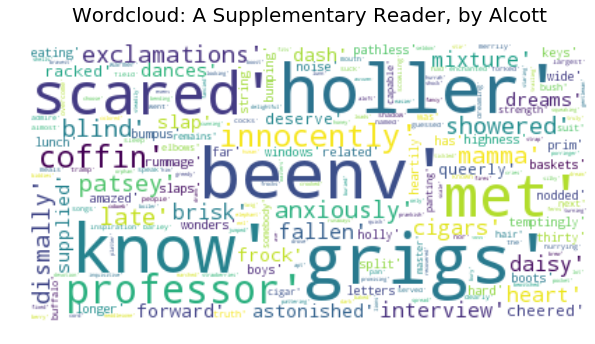

In [56]:
def build_wordcloud(df,title,max_words=100):
    """
    Generate Wordcloud
    :df - input dataframe
    :title - title of ebook
    :max_words - max number of words to render in plot
    Returns - wordcount figure
    """
    text = df.loc[df['title'] == title]['vocabulary'].values[0]
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(str(text))
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Wordcloud: {0}'.format(title),fontsize=20,y=1.06)

build_wordcloud(df,title='A Supplementary Reader, by Alcott')


____

## Homework Questions

- ** Using the helper functions and NLP pipeline above to help answer the following questions**
____

#### 1.	In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. (Various methods will be discussed in the live session.)

- The normalization method implemented below consist of taking the maximum vocabulary size from all of the Children's Instructional Books. The vocabulary size for each book is then normalized (e.g. between 0 and 1) by dividing the total vocabulary size for the respected book by the maximum vocabulary size calculated from the entire series of children's books. 

In [57]:
def normalize_vocab(df):
    """
    Normalize Vocabulary for Each EBook
    vocab_size = vocabulary of each text
    max_vocab  = larges vocabuulary size of any text
    normalized_vocab = ratio of vocab_size to max_vocab
    
    :df - input dataframe with vocabulary of each Ebook
    Returns - dataframe with normalized vocab
    """
    max_vocab = df['vocab_size'].max()
    print('Max Vocab Size: ',max_vocab)
    df['normalized_vocab'] = df['vocab_size'] / max_vocab
    return df

In [66]:
df = normalize_vocab(df)
df[['title','vocab_size','normalized_vocab']].sort_values('normalized_vocab',ascending=True)\
.reset_index(drop=True).head(10)

Max Vocab Size:  13653


,title,vocab_size,normalized_vocab
0,The Project Gutenberg eBook of Stanford Achiev...,123,0.009009
1,The Project Gutenberg eBook of A Bit of Sunshi...,138,0.010108
2,The Project Gutenberg eBook of Child’s Book of...,169,0.012378
3,The Project Gutenberg eBook of The Flag of My ...,327,0.023951
4,The Project Gutenberg eBook of The Flag of My ...,327,0.023951
5,Book about Animals,351,0.025709
6,The Project Gutenberg eBook of A Little Book f...,374,0.027393
7,The Project Gutenberg eBook of Poems Teachers ...,613,0.044899
8,New National First Reader,702,0.051417
9,The Project Gutenberg eBook of Poems Teachers ...,713,0.052223


#### 2.	After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.

- Similarly as described above, but here we take a look at the long words of a text that can be more characteristic and informative about the book itself. In the code below, we find the words from the vocabulary words (e.g. from each book) that are more than 15 characters long and then normalize the total count by the maximum long-word vocabulary size calculated from the entire series of children's books.

In [73]:
def normalize_long_vocab(df):
    """
    Normalize Vocabulary for Each EBook
    
    :df - input dataframe with vocabulary of each Ebook
    Returns - dataframe with normalized long vocab
    """
    max_vocab = df['long_vocab_size'].max()
    print('Max Long-Vocab Size: ',max_vocab)
    df['normalized_long_vocab_size'] = df['long_vocab_size'] / max_vocab
    return df

def long_vocab_size(text,min_char=15):
    """
    Calculating the Long-Word Vocabulary Size of a Text
    
    :df - input dataframe with vocabulary of each Ebook
    :min_char - minimum character length for considering as "long"
    Returns - the total number of instances where a word > min threshold 
    """
    long_words = [w for w in set(text) if len(w) > min_char]
    return len(long_words)

df['long_vocab_size'] = df.apply(lambda x: long_vocab_size(x['vocabulary']),axis=1)
df = normalize_long_vocab(df)
df[['title','vocabulary','long_vocab_size','normalized_long_vocab_size']]\
.sort_values('normalized_long_vocab_size',ascending=False).head(4)

Max Long-Vocab Size:  37


,title,vocabulary,long_vocab_size,normalized_long_vocab_size
53,The Project Gutenberg eBook of Dierenleven in ...,"[aal, aan, aanbreken, aandacht, aandachtig, aa...",37,1.000000
96,The Project Gutenberg eBook of Leçons de Cosmo...,"[a, aa, ab, abaisse, abaissement, abaissons, a...",17,0.459459
71,The Project Gutenberg e-Book of A Modern Histo...,"[a, aaron, aaronical, abandon, abandoned, aban...",16,0.432432
26,The Project Gutenberg eBook of The Ontario Rea...,"[a, abandoned, abandons, abased, abashed, abat...",11,0.297297


#### 3. Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to all of the graded texts documents.

- One observation made from the text difficulty score, normalized vocabulary, and long-vocabulary size is that higher text difficulty scores have a strong correlation with longer vocabulary sized words. However, this may not always correspond with a strong correlation with the actual vocabulary size (e.g. normalized), which can be lower. 

In [76]:
def text_difficulty(lex,norm,long):
    """
    Compute Text Difficulty
    """
    score = (1/3) * lex + (1/3)*norm + (1/3) * long
    return score

df['text_difficulty_score'] = df.apply(lambda x: text_difficulty(x['lex_div'],
                                                                 x['normalized_vocab'],
                                                                 x['long_vocab_size']),axis=1)

# Text Difficulty
df[['title','url','vocab_size','normalized_vocab','normalized_long_vocab_size','text_difficulty_score']]\
.sort_values('text_difficulty_score',ascending=False).head(4).head(10)

,title,url,vocab_size,normalized_vocab,normalized_long_vocab_size,text_difficulty_score
53,The Project Gutenberg eBook of Dierenleven in ...,http://www.gutenberg.org/files/18072/18072-h/1...,4672,0.342196,1.000000,12.447568
96,The Project Gutenberg eBook of Leçons de Cosmo...,http://www.gutenberg.org/files/22917/22917-h/2...,5879,0.430601,0.459459,5.810204
71,The Project Gutenberg e-Book of A Modern Histo...,http://www.gutenberg.org/files/24598/24598-h/2...,12584,0.921702,0.432432,5.640593
26,The Project Gutenberg eBook of The Ontario Rea...,http://www.gutenberg.org/files/19923/19923-h/1...,12834,0.940013,0.297297,3.980056
